In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-05-29 05:53:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-29 05:53:04 (91.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2023-05-29 05:53:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 74.125.143.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.9MB/s    in 4.6s    

2023-05-29 05:53:15 (34.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [4]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [5]:
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

# Models

## Model 0

In [7]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)


16705208/16705208 [==============================] - 1s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [8]:
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230529-055328
Epoch 1/5
24/24 [==============================] - 21s 264ms/step - loss: 1.8487 - accuracy: 0.4307 - val_loss: 1.2902 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 5s 174ms/step - loss: 1.0846 - accuracy: 0.7707 - val_loss: 0.8811 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 7s 270ms/step - loss: 0.7860 - accuracy: 0.8400 - val_loss: 0.7187 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - 5s 175ms/step - loss: 0.6349 - accuracy: 0.8680 - val_loss: 0.6292 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 8s 311ms/step - loss: 0.5480 - accuracy: 0.8773 - val_loss: 0.5853 - val_accuracy: 0.8487


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

In [10]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


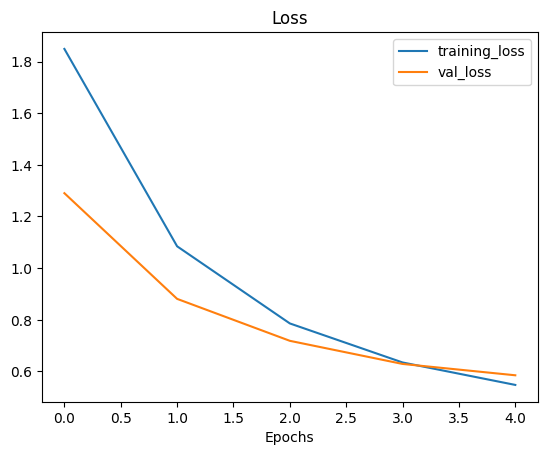

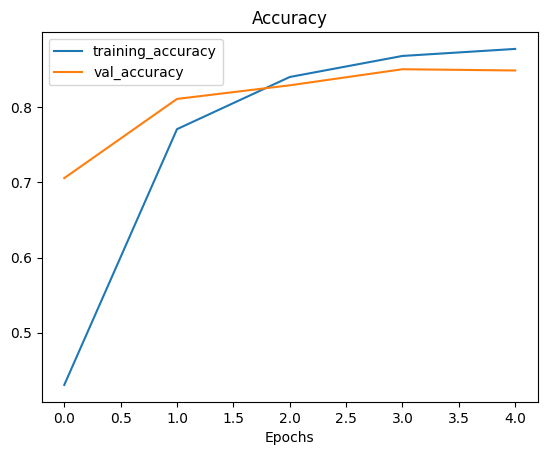

In [11]:
plot_loss_curves(history_10_percent)

# Data Modification

In [12]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-05-29 05:55:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.128, 142.251.18.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  36.6MB/s    in 3.8s    

2023-05-29 05:55:43 (33.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [13]:
walk_through_dir("10_food_classes_1_percent")


There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [14]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing 

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

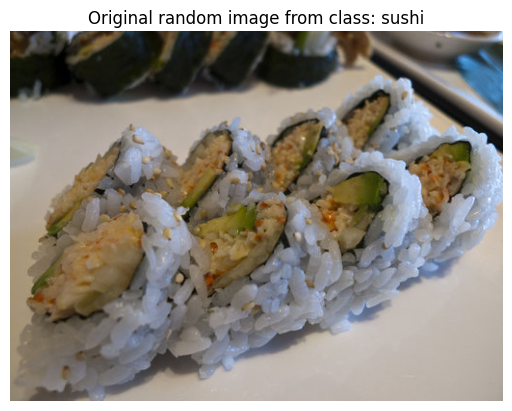

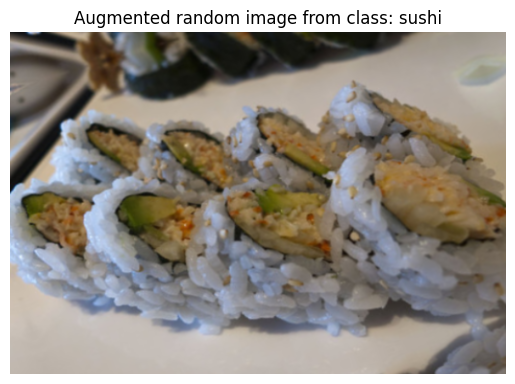

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

# Models

## Model 1: Feature extraction with 1% data

In [17]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

In [18]:
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230529-060023
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.3198 - accuracy: 0.1429 - val_loss: 2.2052 - val_accuracy: 0.1595
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0926 - accuracy: 0.2714 - val_loss: 2.0895 - val_accuracy: 0.2352
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.8843 - accuracy: 0.4143 - val_loss: 1.9841 - val_accuracy: 0.3158
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7554 - accuracy: 0.5000 - val_loss: 1.8802 - val_accuracy: 0.3832
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5630 - accuracy: 0.7143 - val_loss: 1.7944 - val_accuracy: 0.4638


In [19]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 93ms/step - loss: 1.7904 - accuracy: 0.4568


[1.7903648614883423, 0.45680001378059387]

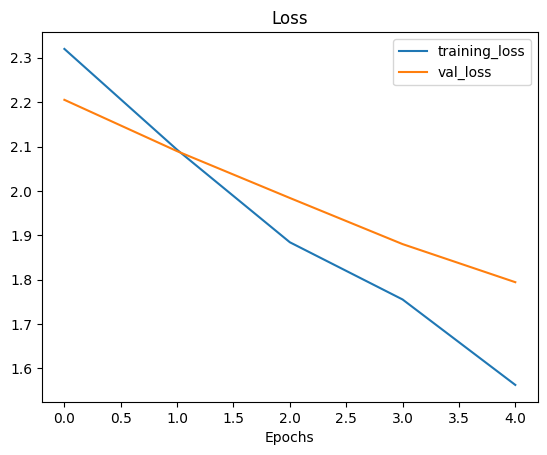

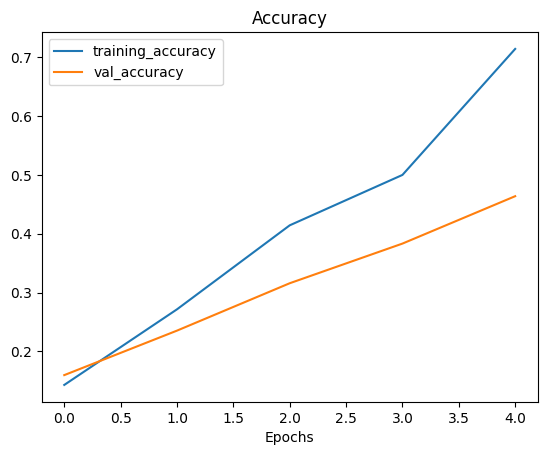

In [20]:
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction with 10% data

In [21]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [22]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [24]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [25]:
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])
     

In [26]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [27]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])
     

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230529-060532


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9785 - accuracy: 0.3640
Epoch 1: val_loss improved from inf to 1.50088, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 25s 690ms/step - loss: 1.9785 - accuracy: 0.3640 - val_loss: 1.5009 - val_accuracy: 0.6217
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3152 - accuracy: 0.6987
Epoch 2: val_loss improved from 1.50088 to 1.04459, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 572ms/step - loss: 1.3152 - accuracy: 0.6987 - val_loss: 1.0446 - val_accuracy: 0.7648
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9923 - accuracy: 0.7747
Epoch 3: val_loss improved from 1.04459 to 0.84142, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 469ms/step - loss: 0.9923 - accuracy: 0.7747 - val

In [28]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 8s 92ms/step - loss: 0.6313 - accuracy: 0.8416


[0.6312586069107056, 0.8416000008583069]

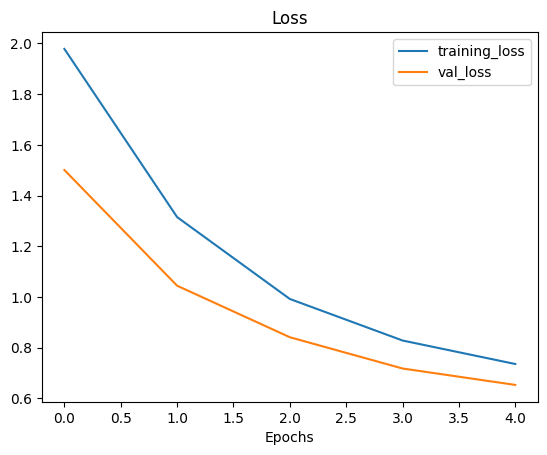

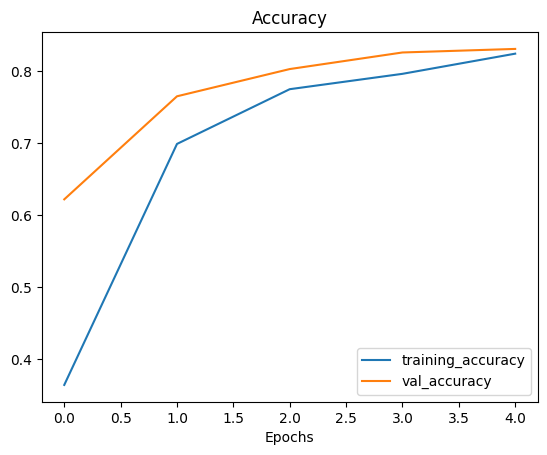

In [29]:
plot_loss_curves(history_10_percent_data_aug)

## Model 3: Fine-tuning on 10% of the data

In [30]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [31]:
model_2.layers


In [32]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [33]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [34]:
initial_epochs

5

In [35]:
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately
     

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230529-061127
Epoch 5/10
24/24 [==============================] - 23s 492ms/step - loss: 0.6182 - accuracy: 0.8253 - val_loss: 0.5136 - val_accuracy: 0.8438
Epoch 6/10
24/24 [==============================] - 11s 465ms/step - loss: 0.4707 - accuracy: 0.8587 - val_loss: 0.5049 - val_accuracy: 0.8372
Epoch 7/10
24/24 [==============================] - 11s 440ms/step - loss: 0.4311 - accuracy: 0.8720 - val_loss: 0.4808 - val_accuracy: 0.8454
Epoch 8/10
24/24 [==============================] - 11s 427ms/step - loss: 0.3760 - accuracy: 0.8933 - val_loss: 0.4663 - val_accuracy: 0.8421
Epoch 9/10
24/24 [==============================] - 10s 387ms/step - loss: 0.3495 - accuracy: 0.8880 - val_loss: 0.4635 - val_accuracy: 0.8388
Epoch 10/10
24/24 [==============================] - 12s 469ms/step - loss: 0.3073 - accuracy: 0.9040 - val_loss: 0.4724 - val_accuracy: 0.8503


In [36]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 66ms/step - loss: 0.4325 - accuracy: 0.8580


In [43]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.36399999260902405, 0.6986666917800903, 0.7746666669845581, 0.7960000038146973, 0.8240000009536743, 0.8253333568572998, 0.8586666584014893, 0.871999979019165, 0.8933333158493042, 0.8880000114440918, 0.9039999842643738]


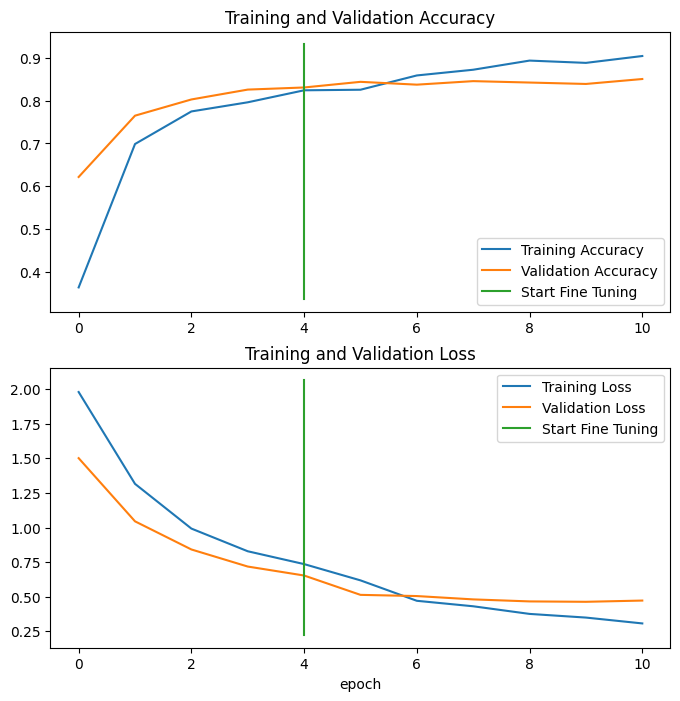

In [44]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

## Model 4: Fine-tuning all of the data

In [45]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-05-29 06:15:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  40.3MB/s    in 13s     

2023-05-29 06:15:35 (38.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [46]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 

In [47]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [48]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.4325 - accuracy: 0.8580


[0.4324595630168915, 0.8579999804496765]

In [49]:
results_fine_tune_10_percent

[0.4324595630168915, 0.8579999804496765]

In [53]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [54]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [55]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230529-062102


Epoch 5/10
235/235 [==============================] - 91s 298ms/step - loss: 0.6497 - accuracy: 0.7964 - val_loss: 0.3901 - val_accuracy: 0.8816
Epoch 6/10
235/235 [==============================] - 60s 251ms/step - loss: 0.5155 - accuracy: 0.8328 - val_loss: 0.4004 - val_accuracy: 0.8701
Epoch 7/10
235/235 [==============================] - 54s 228ms/step - loss: 0.4612 - accuracy: 0.8548 - val_loss: 0.3617 - val_accuracy: 0.8832
Epoch 8/10
235/235 [==============================] - 50s 212ms/step - loss: 0.4150 - accuracy: 0.8696 - val_loss: 0.3213 - val_accuracy: 0.9030
Epoch 9/10
235/235 [==============================] - 46s 195ms/step - loss: 0.3810 - accuracy: 0.8745 - val_loss: 0.3185 - val_accuracy: 0.9095
Epoch 10/10
235/235 [==============================] - 44s 185ms/step - loss: 0.3426 - accuracy: 0.8913 - val_loss: 0.3248 - val_accuracy: 0.8980


In [56]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 75ms/step - loss: 0.2748 - accuracy: 0.9112


[0.274760365486145, 0.9111999869346619]

5
11
[0.36399999260902405, 0.6986666917800903, 0.7746666669845581, 0.7960000038146973, 0.8240000009536743, 0.7964000105857849, 0.8327999711036682, 0.8547999858856201, 0.8695999979972839, 0.8745333552360535, 0.8913333415985107]


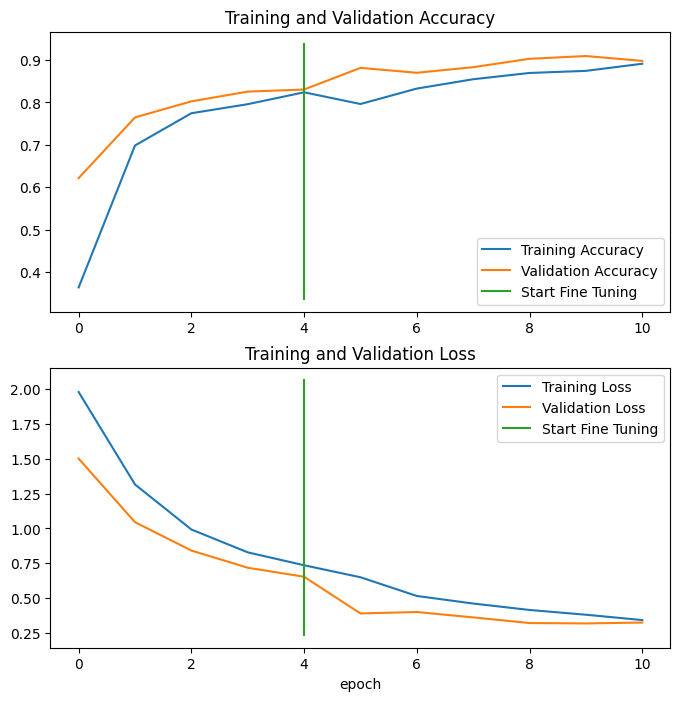

In [57]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)